In [1]:
import torch
import os
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import json
import numpy as np
from PIL import ImageDraw
from data.base_dataset import BaseDataset, get_params, get_transform

In [2]:
class Args:
    name = 'label2city'
    gpu_ids = [0, 1, 2, 3]
    checkpoints_dir = './checkpoints'
    model = 'pix2pixHD'
    norm = 'instance'
    use_dropout = True
    verbose = True
    batchSize = 1
    loadSAize = 512
    fineSize = 512
    label_nc = 20
    input_nc = 3
    output_nc = 3
    dataroot = '../../after_vton_difficult_v2'
    datapairs = 'single.txt'
    resize_or_crop = 'scale_width'
    serial_batches = True
    no_flip = True
    nThreads = 2
    max_dataset_size = float("inf")
    display_winsize = 512
    tf_log = True
    netG = 'global'
    ngf = 64
    n_downsample_global = 4
    n_blocks_global = 4
    n_blocks_local = 3
    n_local_enhancers = 1
    niter_fix_global = 0
    continue_train = True
    display_freq = 100
    print_freq = 100
    save_latest_freq = 1000
    save_epoch_freq = 10 
    no_html = True
    debug = True
    load_pretrain = '../label2city'
    which_epoch = 'latest'
    phase = 'test'
    niter = 100
    niter_decay = 100
    beta1 = 0.5
    lr = 0.0002
    num_D = 2
    n_layers_D = 3
    ndf = 64
    lambda_feat = 10.0
    no_ganFeat_loss = True
    no_vgg_loss = False
    no_lsgan = True
    pool_size = 0
    isTrain = True

opt = Args

In [3]:
import torch.utils.data as data

def get_params(opt, size):
    w, h = size
    new_h = h
    new_w = w
    if opt.resize_or_crop == 'resize_and_crop':
        new_h = new_w = opt.loadSize            
    elif opt.resize_or_crop == 'scale_width_and_crop':
        new_w = opt.loadSize
        new_h = opt.loadSize * h // w

    x = random.randint(0, np.maximum(0, new_w - opt.fineSize))
    y = random.randint(0, np.maximum(0, new_h - opt.fineSize))

def get_transform(method=Image.BICUBIC, normalize=True):
        transform_list = []
        transform_list += [transforms.ToTensor()]
        if normalize:
            transform_list += [transforms.Normalize((0.5, 0.5, 0.5),
                                                    (0.5, 0.5, 0.5))]
        return transforms.Compose(transform_list)
    
class BaseDataset(data.Dataset):
    def __init__(self, opt):
        self.opt = opt
        super(BaseDataset, self).__init__()
        human_names = []
        cloth_names = []
        with open(os.path.join(self.opt.dataroot, self.opt.datapairs), 'r') as f:
            for line in f.readlines():
                h_name, c_name = line.strip().split()
                human_names.append(h_name)
                cloth_names.append(c_name)
        
        self.human_names = human_names
        self.cloth_names = cloth_names
        print(human_names)
        print(cloth_names)
    def image_for_pose(self, dir, transform):
        with open(dir, 'r') as f:
            pose_label = json.load(f)
            pose_data = pose_label['people'][0]['pose_keypoints']
            pose_data = np.array(pose_data)
            pose_data = pose_data.reshape((-1,3))
        point_num = pose_data.shape[0]
        fine_height = 256
        fine_width = 192
        pose_map = torch.zeros(point_num, fine_height, fine_width)
        r = 5
        im_pose = Image.new('L', (fine_width, fine_height))
        pose_draw = ImageDraw.Draw(im_pose)
        for i in range(point_num):
            one_map = Image.new('L', (fine_width, fine_height))
            draw = ImageDraw.Draw(one_map)
            pointx = pose_data[i,0]
            pointy = pose_data[i,1]
            if pointx > 1 and pointy > 1:
                draw.rectangle((pointx-r, pointy-r, pointx+r, pointy+r), 'white', 'white')
                pose_draw.rectangle((pointx-r, pointy-r, pointx+r, pointy+r), 'white', 'white')
            one_map = transform(one_map.convert('RGB'))
            pose_map[i] = one_map[0]
            return pose_map
    
    def __getitem__(self, index):        
        c_name = self.cloth_names[index]
        h_name = self.human_names[index]
        
        dir_label = os.path.join(self.opt.dataroot, 'test_label',h_name.replace(".jpg", ".png"))
        label = Image.open(dir_label).convert('L')
        
        dir_img = os.path.join(opt.dataroot, 'test_img', h_name)
        image = Image.open(dir_img).convert('RGB')

        dir_edge = os.path.join(opt.dataroot, 'test_edge', c_name)
        edge = Image.open(dir_edge).convert('L')
        
        mask = Image.open(dir_img).convert('L')
        
        color = Image.open(dir_edge).convert('RGB')
        
        dir_pose = os.path.join(opt.dataroot, 'test_pose', h_name.replace('.jpg', '_keypoints.json'))
        
        transform_A = get_transform(method=Image.NEAREST, normalize=False)
        label_tensor = transform_A(label) * 255
        transform_B = get_transform()      
        image_tensor = transform_B(image)
        mask_tensor = transform_A(image)
        edge_tensor = transform_A(edge)
        color_tensor = transform_B(color)
        pose_map = self.image_for_pose(dir_pose, transform_B)
        
        return {'label': label_tensor, 'image': image_tensor, 
                             'edge': edge_tensor,'color': color_tensor, 
                             'mask': mask_tensor, 
                             'colormask': mask_tensor,'pose':pose_map}
    
    def __len__(self):
        return len(self.cloth_names)

In [4]:
import models.networks as networks
with torch.no_grad():
    G1 = networks.define_Refine(37, 14, opt.gpu_ids).eval()
save_filename = '%s_net_%s.pth' % (opt.which_epoch, 'G1')
save_path = os.path.join(opt.load_pretrain, save_filename)
G1.load_state_dict(torch.load(save_path))

<All keys matched successfully>

In [5]:
t = BaseDataset(opt)
dataloader = torch.utils.data.DataLoader(
    t,
    batch_size=1,
    shuffle=False)

['000272_0.jpg']
['000101_1.jpg']


In [6]:
len(dataloader)

1

In [7]:
from torch.autograd import Variable

def changearm(old_label):
    label=old_label
    arm1=torch.FloatTensor((label.cpu().numpy()==11).astype(np.int))
    arm2=torch.FloatTensor((label.cpu().numpy()==13).astype(np.int))
    noise=torch.FloatTensor((label.cpu().numpy()==7).astype(np.int))
    label=label*(1-arm1)+arm1*4
    label=label*(1-arm2)+arm2*4
    label=label*(1-noise)+noise*4
    return label

for data in dataloader:
    all_clothes_label = changearm(data['label'])
    mask_clothes = torch.FloatTensor((data['label'].cpu().numpy() == 4).astype(np.int))
    mask_fore = torch.FloatTensor((data['label'].cpu().numpy() > 0).astype(np.int))
    img_fore = data['image'] * mask_fore

    in_label = Variable(data['label'].cuda())
    in_edge = Variable(data['edge'].cuda())
    in_img_fore = Variable(img_fore.cuda())
    in_mask_clothes = Variable(mask_clothes.cuda())
    in_color = Variable(data['color'].cuda())
    in_all_clothes_label = Variable(all_clothes_label.cuda())
    in_image = Variable(data['image'].cuda())
    in_pose = Variable(data['pose'].cuda())
    in_image2 = Variable(data['image'].cuda())
    in_mask_fore = Variable(mask_fore.cuda()) 
    break

<ipython-input-7-4891829f7974>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  arm1=torch.FloatTensor((label.cpu().numpy()==11).astype(np.int))
<ipython-input-7-4891829f7974>:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Dep

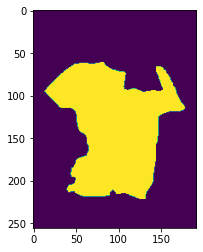

In [8]:
plt.imshow(mask_clothes[0].permute(1,2,0))

In [9]:
def encode_input(label_map, clothes_mask, all_clothes_label):

    size = label_map.size()
    oneHot_size = (size[0], 14, size[2], size[3])
    input_label = torch.cuda.FloatTensor(torch.Size(oneHot_size)).zero_()
    input_label = input_label.scatter_(1, label_map.data.long().cuda(), 1.0)

    masked_label = torch.cuda.FloatTensor(torch.Size(oneHot_size)).zero_()
    masked_label = masked_label.scatter_(1, (label_map * (1 - clothes_mask)).data.long().cuda(), 1.0)

    c_label = torch.cuda.FloatTensor(torch.Size(oneHot_size)).zero_()
    c_label = c_label.scatter_(1, all_clothes_label.data.long().cuda(), 1.0)

    input_label = Variable(input_label)

    return input_label, masked_label, c_label

input_label, masked_label, all_clothes_label = encode_input(in_label, in_mask_clothes, in_all_clothes_label)

In [10]:
import cv2
def gen_noise(shape):
    noise = np.zeros(shape, dtype=np.uint8)
    ### noise
    noise = cv2.randn(noise, 0, 255)
    noise = np.asarray(noise / 255, dtype=np.uint8)
    noise = torch.tensor(noise, dtype=torch.float32)
    return noise.cuda()

In [11]:
arm1_mask = torch.FloatTensor((in_label.cpu().numpy() == 11).astype(np.float)).cuda()
arm2_mask = torch.FloatTensor((in_label.cpu().numpy() == 13).astype(np.float)).cuda()
pre_clothes_mask=torch.FloatTensor((in_edge.detach().cpu().numpy() > 0.5).astype(np.float)).cuda()
clothes = in_color * pre_clothes_mask

shape = pre_clothes_mask.shape

G1_in = torch.cat([pre_clothes_mask, clothes, all_clothes_label, in_pose, gen_noise(shape)], dim=1)
arm_label = G1.refine(G1_in) #input data into G1 (cGAN)

<ipython-input-11-8910edbd37b2>:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  arm1_mask = torch.FloatTensor((in_label.cpu().numpy() == 11).astype(np.float)).cuda()
<ipython-input-11-8910edbd37b2>:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  arm2_mask = torch.FloatTensor((in_label.cpu().numpy() == 13).astype(np.float)).cuda()
<ipyth

In [12]:
sigmoid = torch.nn.Sigmoid()
arm_label = sigmoid(arm_label)

In [13]:
import util.util as util
def generate_label_plain(inputs):
    size = inputs.size()
    pred_batch = []
    for input in inputs:
        input = input.view(1, 14, 256,192)
        pred = np.squeeze(input.data.max(1)[1].cpu().numpy(), axis=0)
        pred_batch.append(pred)

    pred_batch = np.array(pred_batch)
    pred_batch = torch.from_numpy(pred_batch)
    label_batch = pred_batch.view(size[0], 1, 256,192)

    return label_batch

def generate_label_color(inputs):
    label_batch = []
    for i in range(len(inputs)):
        label_batch.append(util.tensor2label(inputs[i], opt.label_nc))
    label_batch = np.array(label_batch)
    label_batch = label_batch * 2 - 1
    input_label = torch.from_numpy(label_batch)
    return input_label

a = generate_label_color(generate_label_plain(input_label)).float().cuda()

In [14]:
def generate_discrete_label(inputs, label_nc, onehot=True, encode=True):
    pred_batch = []
    size = inputs.size()
    for input in inputs:
        input = input.view(1, label_nc, size[2], size[3])
        pred = np.squeeze(input.data.max(1)[1].cpu().numpy(), axis=0)
        pred_batch.append(pred)
    pred_batch = np.array(pred_batch)
    pred_batch = torch.from_numpy(pred_batch)
    label_map = []
    for p in pred_batch:
        p = p.view(1, 256, 192)
        label_map.append(p)
    label_map = torch.stack(label_map, 0)
    if not onehot:
        return label_map.float().cuda()
    size = label_map.size()
    oneHot_size = (size[0], label_nc, size[2], size[3])
    input_label = torch.cuda.FloatTensor(torch.Size(oneHot_size)).zero_()
    input_label = input_label.scatter_(1, label_map.data.long().cuda(), 1.0)

    return input_label
        
armlabel_map = generate_discrete_label(arm_label.detach(), 14, False)

## Instance Segmentation

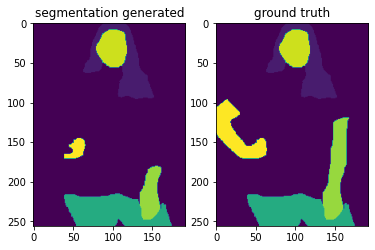

In [15]:
secondInput = (in_label * (1 - in_mask_clothes)).transpose(0, 1)[0].long()

figure = plt.figure()
figure.add_subplot(1,2, 1).set_title('segmentation generated')
plt.imshow((armlabel_map[0].permute(1,2,0).detach().cpu().numpy() + 1)/2)
figure.add_subplot(1,2, 2).set_title('ground truth')
plt.imshow((secondInput.permute(1,2,0).detach().cpu().numpy() + 1)/2)
plt.show(block=True)

In [16]:
import torch.nn.functional as F

def cross_entropy2d(input, target, weight=None, size_average=True):
    n, c, h, w = input.size()
    nt, ht, wt = target.size()

    # Handle inconsistent size between input and target
    if h != ht or w != wt:
        input = F.interpolate(input, size=(ht, wt), mode="bilinear", align_corners=True)

    input = input.transpose(1, 2).transpose(2, 3).contiguous().view(-1, c)
    target = target.view(-1)
    loss = F.cross_entropy(
        input, target, weight=weight, size_average=size_average, ignore_index=250
    )
    return loss
    
CE_loss = cross_entropy2d(arm_label, (in_label * (1 - in_mask_clothes)).transpose(0, 1)[0].long())*10

C:\Users\Tasin\anaconda3\envs\improve\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [17]:
CE_loss

tensor(18.1257, device='cuda:0', grad_fn=<MulBackward0>)

In [18]:
with torch.no_grad():
    G2 = networks.define_Refine(19+18,1,opt.gpu_ids).eval()
save_filename = '%s_net_%s.pth' % (opt.which_epoch, 'G2')
save_path = os.path.join(opt.load_pretrain, save_filename)
G2.load_state_dict(torch.load(save_path))

<All keys matched successfully>

In [19]:
G2_in=torch.cat([pre_clothes_mask,clothes,masked_label,in_pose,gen_noise(shape)],1)
fake_cl=G2.refine(G2_in)
sigmoid=torch.nn.Sigmoid()
fake_cl=sigmoid(fake_cl)

In [20]:
fake_cl.shape

torch.Size([1, 1, 256, 192])

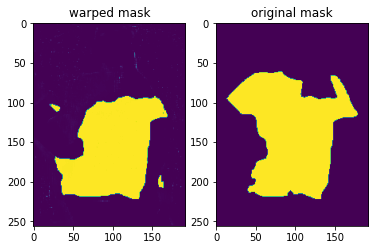

In [21]:
figure = plt.figure()
figure.add_subplot(1,2, 1).set_title('warped mask')
plt.imshow((fake_cl[0].permute(1,2,0).detach().cpu().numpy() + 1)/2)
figure.add_subplot(1,2, 2).set_title('original mask')
plt.imshow((in_mask_clothes[0].permute(1,2,0).detach().cpu().numpy() + 1)/2)

In [22]:
BCE = torch.nn.BCEWithLogitsLoss()
CE_loss += BCE(fake_cl, in_mask_clothes)*10

In [23]:
CE_loss

tensor(24.3086, device='cuda:0', grad_fn=<AddBackward0>)

In [24]:
def morpho(mask, iter, bigger=True):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    new = []
    for i in range(len(mask)):
        tem = mask[i].cpu().detach().numpy().squeeze().reshape(256, 192, 1)*255
        tem = tem.astype(np.uint8)
        if bigger:
            tem = cv2.dilate(tem, kernel, iterations=iter)
        else:
            tem = cv2.erode(tem, kernel, iterations=iter)
        tem = tem.astype(np.float64)
        tem = tem.reshape(1, 256, 192)
        new.append(tem.astype(np.float64)/255.0)
    new = np.stack(new)
    new = torch.FloatTensor(new).cuda()
    return new

fake_cl_dis = torch.FloatTensor(
            (fake_cl.detach().cpu().numpy() > 0.5).astype(np.float)).cuda()
fake_cl_dis = morpho(fake_cl_dis, 1, True)

<ipython-input-24-de969e3d0a2b>:19: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  (fake_cl.detach().cpu().numpy() > 0.5).astype(np.float)).cuda()


In [25]:
def generate_discrete_label(inputs, label_nc,onehot=True,encode=True):
    pred_batch = []
    size = inputs.size()
    for input in inputs:
        input = input.view(1, label_nc, size[2], size[3])
        pred = np.squeeze(input.data.max(1)[1].cpu().numpy(), axis=0)
        pred_batch.append(pred)
    pred_batch = np.array(pred_batch)
    pred_batch = torch.from_numpy(pred_batch)
    label_map = []
    for p in pred_batch:
        p = p.view(1, 256, 192)
        label_map.append(p)
    label_map = torch.stack(label_map, 0)
    if not onehot:
        return label_map.float().cuda()
    size = label_map.size()
    oneHot_size = (size[0], label_nc, size[2], size[3])
    input_label = torch.cuda.FloatTensor(torch.Size(oneHot_size)).zero_()
    input_label = input_label.scatter_(1, label_map.data.long().cuda(), 1.0)
    return input_label

In [26]:
fake_cl_dis = torch.FloatTensor(
            (fake_cl.detach().cpu().numpy() > 0.5).astype(np.float)).cuda()
fake_cl_dis = morpho(fake_cl_dis, 1, True)
new_arm1_mask = torch.FloatTensor(
    (armlabel_map.cpu().numpy() == 11).astype(np.float)).cuda()
new_arm2_mask = torch.FloatTensor(
    (armlabel_map.cpu().numpy() == 13).astype(np.float)).cuda()
fake_cl_dis = fake_cl_dis*(1 - new_arm1_mask)*(1-new_arm2_mask)
fake_cl_dis *= mask_fore.cuda()
arm1_occ=in_mask_clothes*new_arm1_mask
arm2_occ=in_mask_clothes*new_arm2_mask
bigger_arm1_occ = morpho(arm1_occ, 10)
bigger_arm2_occ = morpho(arm2_occ, 10)
arm1_full=arm1_occ+(1-in_mask_clothes)*arm1_mask
arm2_full=arm2_occ+(1-in_mask_clothes)*arm2_mask
armlabel_map*=(1-new_arm1_mask)
armlabel_map*=(1-new_arm2_mask)
armlabel_map=armlabel_map*(1-arm1_full)+arm1_full*11
armlabel_map=armlabel_map*(1-arm2_full)+arm2_full*13

<ipython-input-26-6d068a8f7a2f>:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  (fake_cl.detach().cpu().numpy() > 0.5).astype(np.float)).cuda()
<ipython-input-26-6d068a8f7a2f>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  (armlabel_map.cpu().numpy() == 11).astype(np.float)).cuda()
<ipython-input-26-6d068a8f7a2f>:7: DeprecationWarning:

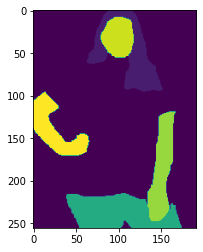

In [27]:
plt.imshow(armlabel_map[0].permute(1,2,0).detach().cpu().numpy())

In [28]:
with torch.no_grad():
    Unet = networks.define_UnetMask(4, opt.gpu_ids).eval()
save_filename = '%s_net_%s.pth' % (opt.which_epoch, 'U')
save_path = os.path.join(opt.load_pretrain, save_filename)
Unet.load_state_dict(torch.load(save_path))
fake_c, warped, warped_mask,rx,ry,cx,cy,rg,cg = Unet(clothes, in_mask_clothes,pre_clothes_mask)

C:\Users\Tasin\anaconda3\envs\improve\lib\site-packages\torch\nn\functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
C:\Users\Tasin\anaconda3\envs\improve\lib\site-packages\torch\nn\functional.py:3828: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


In [29]:
warped_mask.size()

torch.Size([1, 1, 256, 192])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


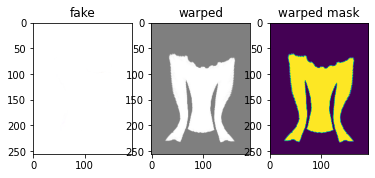

In [30]:
figure = plt.figure()
figure.add_subplot(1,3, 1).set_title('fake')
plt.imshow((fake_c[0].permute(1,2,0).detach().cpu().numpy() + 1)/2)
figure.add_subplot(1,3, 2).set_title('warped')
plt.imshow((warped[0].permute(1,2,0).detach().cpu().numpy() + 1)/2)
figure.add_subplot(1,3, 3).set_title('warped mask')
plt.imshow((warped_mask[0].permute(1,2,0).detach().cpu().numpy() + 1)/2)


In [31]:
composition_mask = fake_c[:, 3, :, :]
fake_c=fake_c[:,0:3,:,:]
tanh = torch.nn.Tanh()
fake_c=tanh(fake_c)
composition_mask=sigmoid(composition_mask)

In [32]:
composition_mask.size()

torch.Size([1, 256, 192])

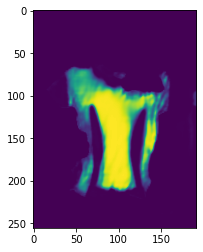

In [33]:
plt.imshow(composition_mask.permute(1,2,0).detach().cpu().numpy()+1)

In [34]:
def ger_average_color(mask,arms):
    color = torch.zeros(arms.shape).cuda()
    for i in range(arms.shape[0]):
        count = len(torch.nonzero(mask[i, :, :, :]))
        if count < 10:
            color[i, 0, :, :]=0
            color[i, 1, :, :]=0
            color[i, 2, :, :]=0

        else:
            color[i,0,:,:]=arms[i,0,:,:].sum()/count
            color[i,1,:,:]=arms[i,1,:,:].sum()/count
            color[i,2,:,:]=arms[i,2,:,:].sum()/count
    return color
    
skin_color=ger_average_color((arm1_mask+arm2_mask-arm2_mask*arm1_mask),(arm1_mask+arm2_mask-arm2_mask*arm1_mask)*in_image)

In [35]:
skin_color.size()

torch.Size([1, 3, 256, 192])

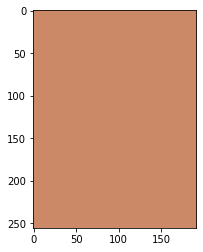

In [36]:
plt.imshow((skin_color[0].permute(1,2,0).detach().cpu().numpy()+1)/2)

In [37]:
occlude = (1 - bigger_arm1_occ * (arm2_mask + arm1_mask+in_mask_clothes)) * \
            (1 - bigger_arm2_occ * (arm2_mask + arm1_mask+in_mask_clothes))
occlude = occlude.cuda()
img_hole_hand = img_fore.cuda() * \
            (1 - in_mask_clothes) * occlude * (1 - fake_cl_dis.cuda())

In [38]:
img_hole_hand.size()

torch.Size([1, 3, 256, 192])

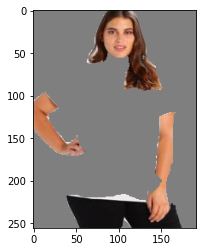

In [39]:
plt.imshow((img_hole_hand[0].permute(1,2,0).detach().cpu().numpy()+1)/2)

In [40]:
G_in=torch.cat([img_hole_hand,masked_label,in_image2*in_mask_clothes,skin_color,gen_noise(shape)],1)

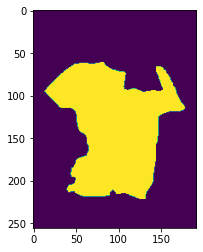

In [41]:
plt.imshow((in_mask_clothes[0].permute(1,2,0).detach().cpu().numpy()+1)/2)

In [42]:
with torch.no_grad():
    G = networks.define_Refine(24, 3, opt.gpu_ids).eval()
save_filename = '%s_net_%s.pth' % (opt.which_epoch, 'G')
save_path = os.path.join(opt.load_pretrain, save_filename)
G.load_state_dict(torch.load(save_path))
fake_image=G.refine(G_in.detach())
tanh = torch.nn.Tanh()
fake_image=tanh(fake_image)

In [43]:
fake_image.size()

torch.Size([1, 3, 256, 192])

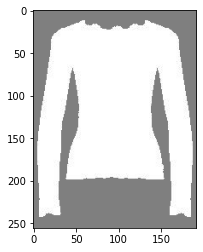

In [44]:
plt.imshow((clothes[0].permute(1,2,0).detach().cpu().numpy()+1)/2)

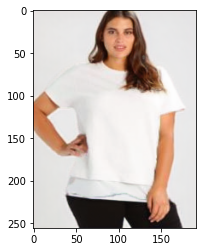

In [45]:
plt.imshow((fake_image[0].permute(1,2,0).detach().cpu().numpy()+1)/2)